In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)


67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913
load *SessionPulses.Events.mat failed


In [3]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [4]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [5]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


# sequence within block

In [10]:
np.array([1,2,3,4,5,6,7])[1::2]

array([2, 4, 6])

In [48]:
def sort_fr_map(fr_map):
    peaks_loc = fr_map.idxmax(axis=1)
    peaks_loc.loc[fr_map.sum(axis=1)==0] = -1 # make the not firing ones go to the top
    peaks_loc_sorted = peaks_loc.sort_values()
    order = peaks_loc_sorted.index
    return order

def plot_population_sequence(fr_map,order=None,fr_map_for_order=None,fig=None,ax=None,normalize=True,vmax=None):
    '''
    if fr_map_for_order and order: use fr_map_for_order to compute order
    '''
    if ax is None:
        fig,ax=plt.subplots()
    
    if order is None:
        if fr_map_for_order is not None:
            order = sort_fr_map(fr_map_for_order)
        else:
            order = sort_fr_map(fr_map)        
    fr_map_sorted = fr_map.loc[order]
    if normalize:
        fr_map_sorted_normed = fr_map_sorted / fr_map_sorted.max(axis=1).values[:,None]
    else:
        fr_map_sorted_normed = fr_map_sorted
    if vmax is None:
        vmax = fr_map_sorted_normed.max().max() * 0.95
    ax.imshow(fr_map_sorted_normed,aspect='auto',vmax=vmax)
    
    return fig, ax, order
    
def plot_multi_sequences_multi_orders(fr_map_l,order_l=None,fig=None,axs=None,normalize=True,reduce=False,vmax=None):
    '''
    if reduce: need to average before plotting
    '''
    nmap = len(fr_map_l)
    if order_l is None:
        order_l = [None] * nmap
    assert len(order_l) == nmap
    if axs is None:
        fig,axs = plt.subplots(nmap,nmap,figsize=(nmap * 4,nmap*4))
    
    for ii in range(nmap):
        order = order_l[ii]
        if reduce:
            ntrials_sub = fr_map_l[ii].shape[1]
            fr_map_for_plot = fr_map_l[ii].iloc[:,::2].mean(axis=1).unstack()
            fr_map_for_order = fr_map_l[ii].iloc[:,1::2].mean(axis=1).unstack()
        else:
            fr_map_for_plot = fr_map_l[ii]
            fr_map_for_order = None
            
        fig,ax,order=plot_population_sequence(fr_map_for_plot,order=order,fr_map_for_order=fr_map_for_order,fig=fig,ax=axs[ii,ii],normalize=normalize,vmax=vmax)
        order_l[ii] = order
    
    for ii in range(nmap):
        order = order_l[ii]
        for jj in range(nmap):
            if ii!=jj:
                if reduce:
                    fr_map_for_plot = fr_map_l[jj].mean(axis=1).unstack()
                else:
                    fr_map_for_plot = fr_map_l[jj]
                fig,ax,_=plot_population_sequence(fr_map_for_plot,order=order,fr_map_for_order=None,fig=fig,ax=axs[ii,jj],normalize=normalize,vmax=vmax)
    
    return fig,axs,order_l
    
def divide_fr_map_trial_into_blocks(fr_map_trial_df,nblocks=3,reduce=True): 
    '''
    fr_map_trial_df: (nneuron x nposbins) x ntrials
    reduce: average into one ratemap, or keep the trials
    '''
    fr_map_trial_df = fr_map_trial_df.dropna(axis=1)
    ntrials = fr_map_trial_df.shape[1]
    edges = np.linspace(0,ntrials,nblocks+1).astype(int)
    fr_map_l = []
    st_end_l = []
    for i in range(len(edges)-1):
        if reduce:
            fr_map_one = fr_map_trial_df.loc[:,edges[i]:edges[i+1]].mean(axis=1).unstack()
        else:
            fr_map_one = fr_map_trial_df.loc[:,edges[i]:edges[i+1]]
        fr_map_l.append(fr_map_one)
        st_end_l.append((edges[i],edges[i+1]))
    return fr_map_l,st_end_l
    
    
    


    

In [61]:
task_ind,tt_ind = 0,0
place_cell_ind = pf_res['avg']['params'][(task_ind,tt_ind)].loc['fr_peak'].index.get_level_values(0).unique()
fr_map_trial_df = fr_map_trial_df_d.loc[task_ind,tt_ind]
fr_map_trial_df = fr_map_trial_df.loc[place_cell_ind].dropna(axis=1)
fr_map_trial_df = fr_map_trial_df.groupby(level=0).apply(lambda x:x/x.max().max())
fr_map_l,st_end_l = divide_fr_map_trial_into_blocks(fr_map_trial_df,5,reduce=False)

(<Figure size 1440x1440 with 25 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object),
 [Float64Index([371.0, 430.0, 436.0, 391.0, 440.0, 250.0, 115.0, 374.0, 351.0,
                179.0,
                ...
                336.0, 183.0, 194.0, 206.0,  40.0, 133.0, 211.0, 214.0,  93.0,
                146.0],
               dtype='float64', length=263),
  Float64Index([436.0, 430.0, 229.0,  91.0, 196.0, 195.0, 259.0, 390.0, 257.0,
                221.0,
                ...
                183.0,  54.0, 185.0, 284.0, 418.0, 114.0, 

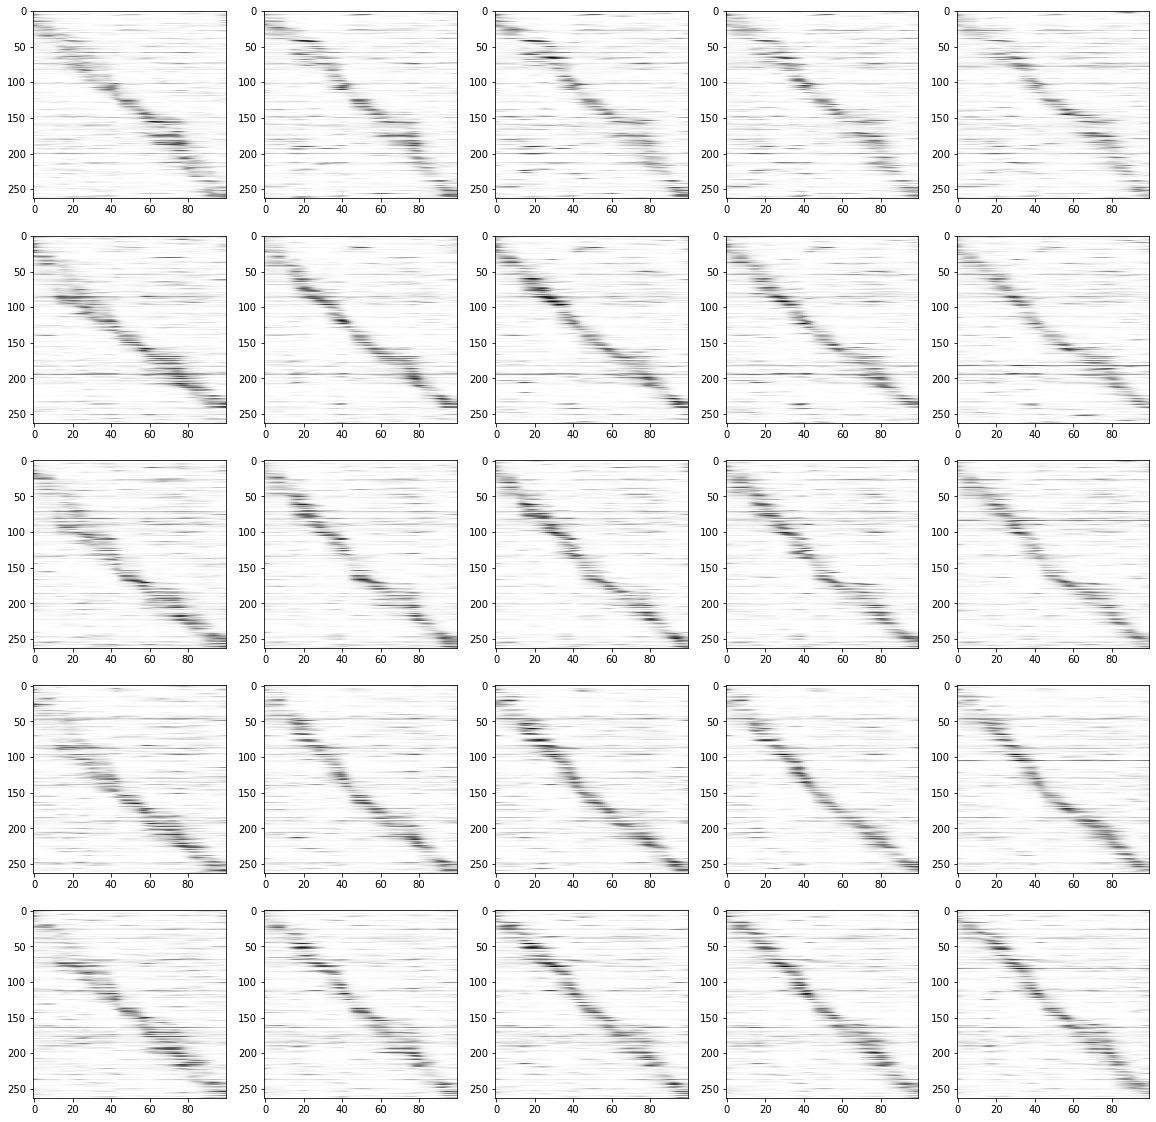

In [62]:
%matplotlib inline
plot_multi_sequences_multi_orders(fr_map_l,order_l=None,fig=None,axs=None,normalize=False,reduce=True)



(<Figure size 864x864 with 9 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 [Float64Index([430.0, 436.0, 278.0, 187.0, 346.0, 229.0, 188.0, 195.0, 222.0,
                246.0,
                ...
                356.0, 244.0, 275.0,  93.0, 214.0, 133.0,  94.0, 114.0, 167.0,
                194.0],
               dtype='float64', length=263),
  Float64Index([362.0, 391.0, 196.0, 222.0, 179.0, 246.0,  34.0, 113.0, 257.0,
                259.0,
                ...
                 44.0, 418.0, 194.0, 133.0, 167.0, 183.0, 211.0, 102.0, 161.0,
                305.0],
               dtype='float64', length=263),
  Float64Index([188.0, 132.0, 222.0, 198.0,  91.0, 246.0, 249.0, 250.0, 196.0,
                259.0,
                ...
                133.0,  40.0, 211.0, 113.0, 194.0, 167.0, 262.0, 418.0, 224.0,
                114.0],
         

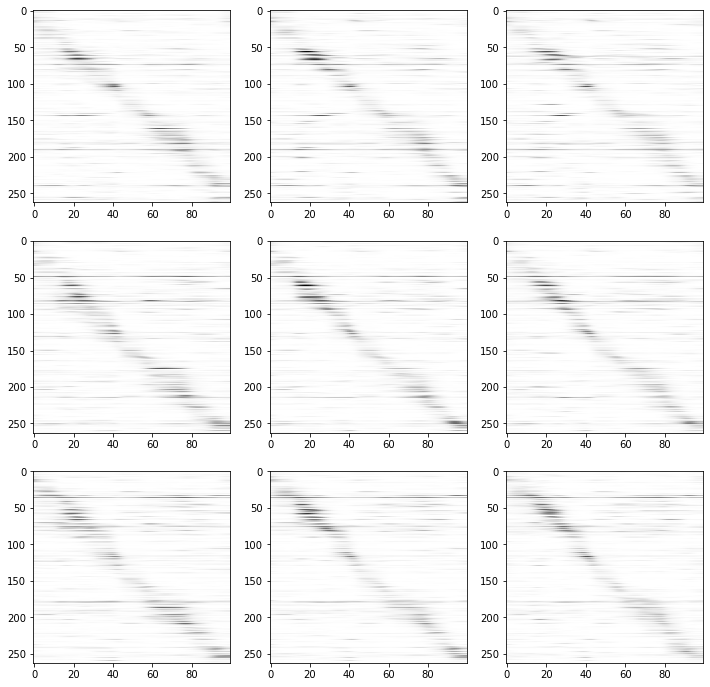

In [43]:
%matplotlib inline
plot_multi_sequences_multi_orders(fr_map_l,order_l=None,fig=None,axs=None,normalize=False,reduce=True)



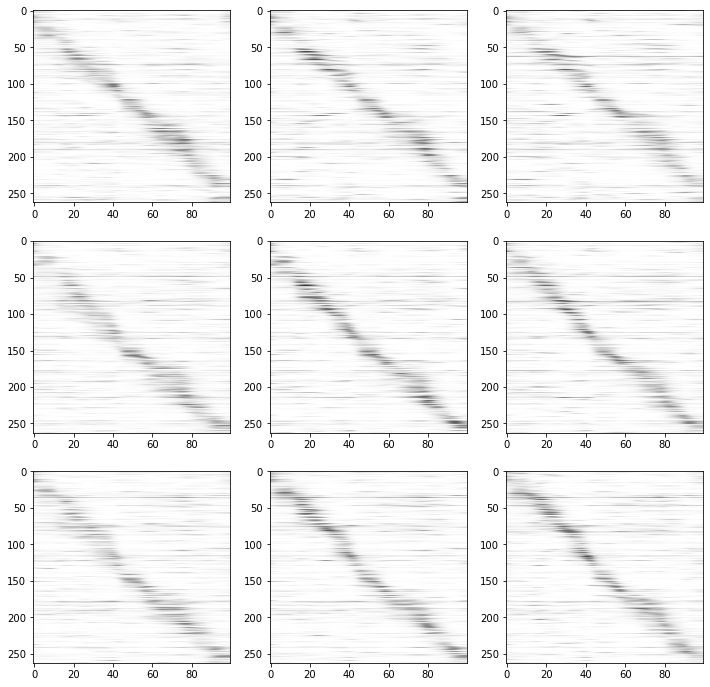

In [52]:
%matplotlib inline
fig,axs,order_l=plot_multi_sequences_multi_orders(fr_map_l,order_l=None,fig=None,axs=None,normalize=False,reduce=True,vmax=0.9)




# divide into switch and nonswitch cells

In [ ]:
task_ind,tt_ind = 0,0

In [69]:
change_df_onett = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)

/tmp/ipykernel_226646/2390625453.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  change_df_onett = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)


In [79]:
nonsw_fields = change_df_onett.loc[(change_df_onett.abs().sum(axis=1)==0)].index
sw_fields = change_df_onett.loc[(change_df_onett.abs().sum(axis=1)>0)].index

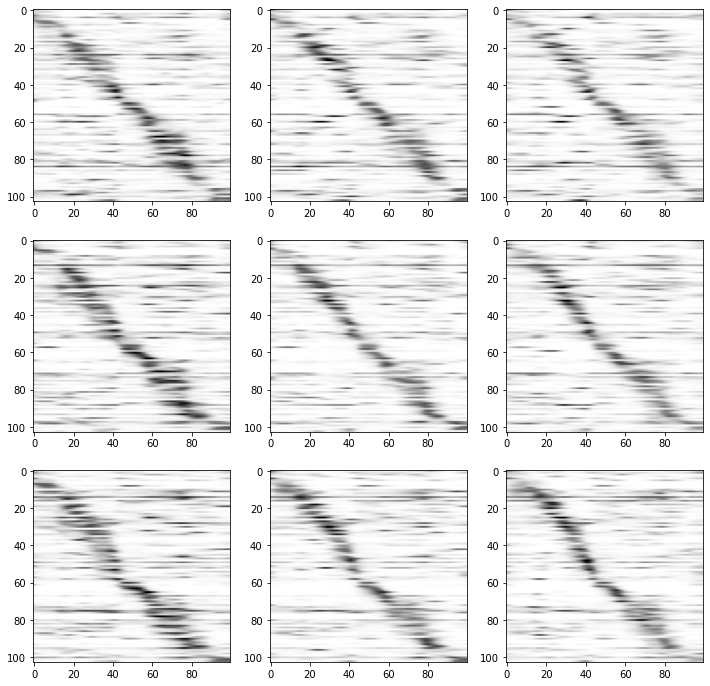

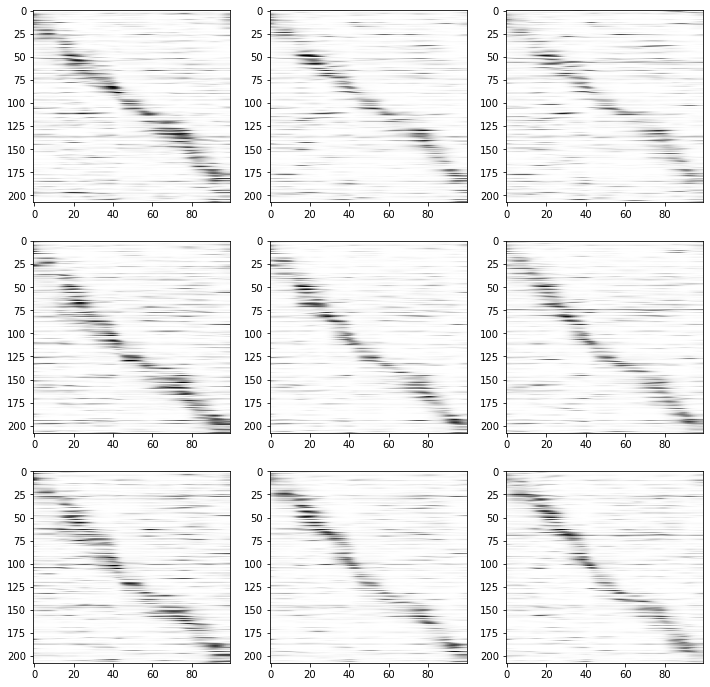

In [81]:
for place_cell_ind in [nonsw_fields,sw_fields]:
    place_cell_ind = place_cell_ind.get_level_values(0).unique()
    fr_map_trial_df = fr_map_trial_df_d.loc[task_ind,tt_ind]
    fr_map_trial_df = fr_map_trial_df.loc[place_cell_ind].dropna(axis=1)
    fr_map_trial_df = fr_map_trial_df.groupby(level=0).apply(lambda x:x/x.max().max())
    fr_map_l,st_end_l = divide_fr_map_trial_into_blocks(fr_map_trial_df,3,reduce=False)
    plot_multi_sequences_multi_orders(fr_map_l,order_l=None,fig=None,axs=None,normalize=False,reduce=True)

In [78]:
nonsw_fields

MultiIndex([( 27, 0),
            ( 29, 1),
            ( 29, 2),
            ( 32, 1),
            ( 33, 0),
            ( 34, 1),
            ( 35, 1),
            ( 36, 1),
            ( 39, 0),
            ( 43, 2),
            ...
            (335, 0),
            (341, 0),
            (343, 0),
            (374, 1),
            (377, 0),
            (379, 0),
            (393, 0),
            (395, 0),
            (412, 0),
            (421, 0)],
           length=119)

In [21]:
fr_map.idxmax(axis=1)

1.0      79
2.0       0
3.0      24
27.0     78
29.0     22
         ..
476.0    29
477.0     0
478.0    91
479.0    66
480.0    80
Length: 422, dtype: int64